# Visualizing COVID-19 cases in Ontario
By Kendra Oudyk

### How to run this code
<font color='red'>In the above ribbon, click **cell** and then click **Run All**</font> 

In [1]:
import pandas as pd 
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.widgets import CheckButtons
import requests
from io import StringIO 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() 

%matplotlib inline


## Load the data from the data.ontario.ca website
Read it into a pandas dataframe, which is like a table)

In [2]:
data_url = 'https://data.ontario.ca/dataset/f4112442-bdc8-45d2-be3c-12efae72fb27/resource/455fd63b-603d-4608-8216-7d8647f43350/download/conposcovidloc.csv'
response = requests.get(data_url)
csv_string = response.content.decode('utf-8')
cases = pd.read_csv(StringIO(csv_string))
cases.head(4) # see the first few columns

,Row_ID,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Outcome1,Outbreak_Related,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Website,Reporting_PHU_Latitude,Reporting_PHU_Longitude
0,1,2020-07-27,2020-07-30,2020-07-30,2020-07-29,20s,FEMALE,CC,Not Resolved,Yes,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
1,2,2020-07-20,2020-07-25,2020-07-26,2020-07-25,60s,MALE,CC,Resolved,Yes,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
2,3,2020-07-15,2020-07-16,2020-07-16,2020-07-15,40s,MALE,No Epi-link,Resolved,Yes,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
3,4,2020-07-21,2020-07-21,NaN,NaN,30s,FEMALE,No Epi-link,Resolved,Yes,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893


## Define the population of each phu

In [3]:
phu_populations =   {'Algoma Public Health Unit': 114434,
                     'Brant County Health Unit': 155203,
                     'Chatham-Kent Health Unit': 106317,
                     'Durham Region Health Department': 712402,
                     'Eastern Ontario Health Unit': 208711,
                     'Grey Bruce Health Unit': 169884,
                     'Haldimand-Norfolk Health Unit': 114081,
                     'Haliburton, Kawartha, Pine Ridge District Health Unit': 188937,
                     'Halton Region Health Department': 619087,
                     'Hamilton Public Health Services': 592163,
                     'Hastings and Prince Edward Counties Health Unit': 168493,
                     'Huron Perth District Health Unit': 139757,
                     'Kingston, Frontenac and Lennox & Addington Public Health': 212719,
                     'Lambton Public Health': 130964,
                     'Leeds, Grenville and Lanark District Health Unit': 173170,
                     'Middlesex-London Health Unit': 507524,
                     'Niagara Region Public Health Department': 472485,
                     'North Bay Parry Sound District Health Unit': 129752,
                     'Northwestern Health Unit': 87675,
                     'Ottawa Public Health': 1054656,
                     'Peel Public Health': 1605952,
                     'Peterborough Public Health': 147977,
                     'Porcupine Health Unit': 83441,
                     'Region of Waterloo, Public Health': 584361,
                     'Renfrew County and District Health Unit': 108631,
                     'Simcoe Muskoka District Health Unit': 599589,
                     'Southwestern Public Health': 211498,
                     'Sudbury & District Health Unit': 199023,
                     'Thunder Bay District Health Unit': 149960,
                     'Timiskaming Health Unit': 32689,
                     'Toronto Public Health': 3120358,
                     'Wellington-Dufferin-Guelph Public Health': 311908,
                     'Windsor-Essex County Health Unit': 424830,
                     'York Region Public Health Services': 1225797}

## Timeline
### turn the dates into integers, which are easier to deal with


In [4]:
cases['Date'] = cases['Accurate_Episode_Date']
cases = cases.dropna(subset=['Date'])
cases['Date'] = [int(str(s).replace('-', '')) for s in cases['Date']]

### get a list of all dates until today
We want to begin at Feb 15, 2020, but we're looking at cases in 14-day periods, so we'll start the timeline 14 days before (inclusive of) Feb 15.  

In [5]:
d1 = datetime.date(2020,2,15)
d2 = datetime.date.today()
datetimes = [(d1 + datetime.timedelta(days=x)) for x in range((d2-d1).days + 1)]
dates = [int(str(s).replace('-', '')) for s in datetimes]

## Get the relevant data 
I.e., get the data for each PHU and day from the *cases* dataframe, and store it in a new dataframe called *data*. *data* has a row for each day, and a column for each PHU


In [6]:
# initialize dataframe
data = pd.DataFrame()
data['Date'] = dates

days_in_range = 14
overall_begin_date = 20200215 # february 15 2020
phus = np.unique(cases['Reporting_PHU'])  
for phu in phus:
    population = int(phu_populations[phu])
    
    # select the cases for the given PHU
    phu_cases = cases[cases['Reporting_PHU'] == phu]
    
    daily_rate = []
    for n, date in enumerate(dates):
        if date >= overall_begin_date: # if it's after Feb 15
            # select the cases for the given date, in the given PHU
            i_begin_date = n - days_in_range + 1 # add 1 because it's 14 days inclusive
            begin_date = dates[i_begin_date]
            end_date = date
            phu_cases_in_current_dates = phu_cases[phu_cases['Date'].\
                                                   between(begin_date, end_date)]
            

            # calculate the infection rate
            n_cases = len(phu_cases_in_current_dates)
            rate = n_cases / population * 10000
            daily_rate.append(rate)
    data[phu] = daily_rate

### Inspect the first 3 rows
to see if the dates start as expected

In [7]:
data.head(3)

,Date,Algoma Public Health Unit,Brant County Health Unit,Chatham-Kent Health Unit,Durham Region Health Department,Eastern Ontario Health Unit,Grey Bruce Health Unit,Haldimand-Norfolk Health Unit,"Haliburton, Kawartha, Pine Ridge District Health Unit",Halton Region Health Department,...,Renfrew County and District Health Unit,Simcoe Muskoka District Health Unit,Southwestern Public Health,Sudbury & District Health Unit,Thunder Bay District Health Unit,Timiskaming Health Unit,Toronto Public Health,Wellington-Dufferin-Guelph Public Health,Windsor-Essex County Health Unit,York Region Public Health Services
0,20200215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20200216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20200217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Inspect the last 3 rows
to see if the dates end as expected

In [8]:
data.tail(3)

,Date,Algoma Public Health Unit,Brant County Health Unit,Chatham-Kent Health Unit,Durham Region Health Department,Eastern Ontario Health Unit,Grey Bruce Health Unit,Haldimand-Norfolk Health Unit,"Haliburton, Kawartha, Pine Ridge District Health Unit",Halton Region Health Department,...,Renfrew County and District Health Unit,Simcoe Muskoka District Health Unit,Southwestern Public Health,Sudbury & District Health Unit,Thunder Bay District Health Unit,Timiskaming Health Unit,Toronto Public Health,Wellington-Dufferin-Guelph Public Health,Windsor-Essex County Health Unit,York Region Public Health Services
172,20200805,0.0,0.451022,7.618725,0.393037,0.191653,0.117727,0.701256,0.158783,0.129223,...,0.0,0.183459,3.829823,0.854173,0.333422,0.0,0.538400,0.192364,4.142834,0.522109
173,20200806,0.0,0.386590,7.054375,0.393037,0.143739,0.117727,0.701256,0.158783,0.113070,...,0.0,0.166781,3.404288,0.854173,0.266738,0.0,0.480714,0.224425,3.601441,0.530267
174,20200807,0.0,0.257727,6.678142,0.378999,0.143739,0.117727,0.701256,0.105855,0.096917,...,0.0,0.166781,3.026033,0.854173,0.266738,0.0,0.432643,0.192364,2.636349,0.522109


## Visualize the timelines for all PHUs on the same interactive plot

<IPython.core.display.Javascript object>


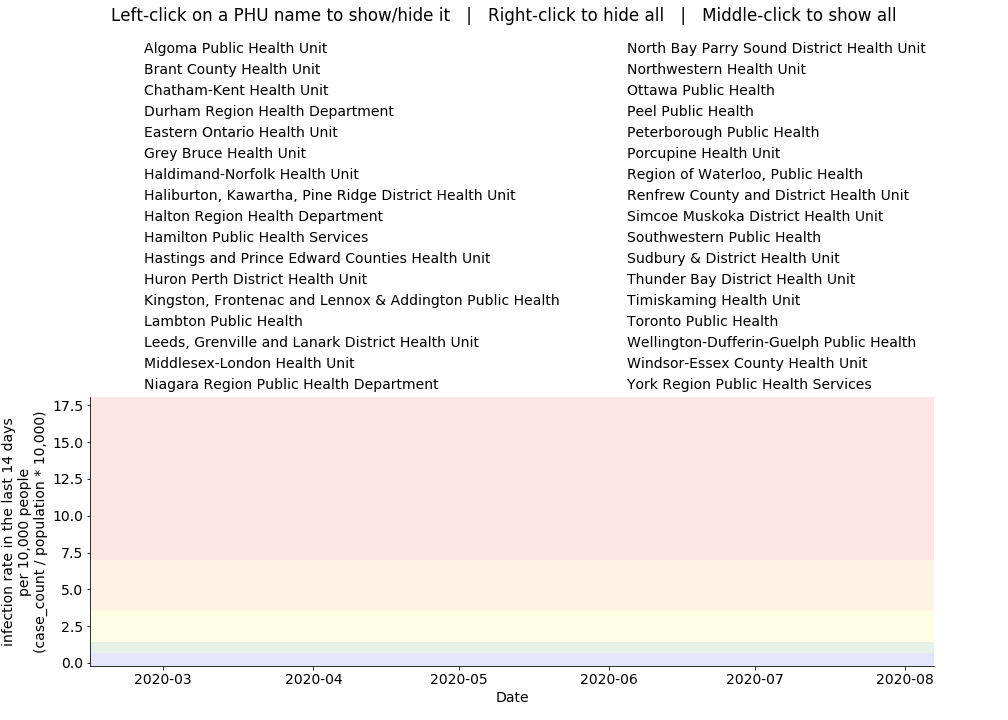

In [9]:
# This code was based on https://stackoverflow.com/questions/31410043/hiding-lines-after-showing-a-pyplot-figure/31417070

%matplotlib notebook

matplotlib.rc('font', size = 14)

linewidth=4
alpha=.1
ymax = np.max(data.loc[:, data.columns != 'Date'].values) + 2
ymin = - .2
days = 14

def main():
    
    NUM_COLORS = 34
    LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
    COLORS = ['DarkRed', 'red', 'DarkKhaki', 'Lime', 'Green', 'DeepSkyBlue', 'Blue', 'Violet', 'black']
    LINE_COLORS = []
    for color in COLORS:
        for style in LINE_STYLES:
            LINE_COLORS.append(color)
    NUM_STYLES = len(LINE_STYLES)
    cm = plt.get_cmap('gist_rainbow')
    cm = plt.get_cmap('nipy_spectral')
    
    x = datetimes
            
    fig, ax = plt.subplots(figsize=(14,10))
    ax.set_xlim(datetimes[0], datetimes[-1])
    ax.axhspan(ymin, 0.05*days, facecolor='blue', alpha=alpha)
    ax.axhspan(0.05*days, 0.1*days, facecolor='green', alpha=alpha)
    ax.axhspan(0.1*days, 0.25*days, facecolor='yellow', alpha=alpha)
    ax.axhspan(0.25*days, 0.5*days, facecolor='darkorange', alpha=alpha)
    ax.axhspan(0.5*days, ymax, facecolor='red', alpha=alpha)
    
    for i, phu in enumerate(phus[0:]):
        y = data[phu]
        #color = cm(i//NUM_STYLES*float(NUM_STYLES)/NUM_COLORS)
        color = LINE_COLORS[i]
        linestyle = LINE_STYLES[i%NUM_STYLES]
        ax.plot(x, y, label=phu, color=color, linestyle=linestyle)
        #ax.plot(x, y, label=phu) # default color scheme

    ax.legend(loc='best', bbox_to_anchor=(0.01, 1),
              ncol=2, borderaxespad=0, title=' ',#title='Regional public health unit',
              frameon=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel('infection rate in the last 14 days\nper 10,000 people\n(case_count / population * 10,000)')
    ax.set_xlabel('Date')

    fig.subplots_adjust(top=0.4)
    fig.suptitle('Left-click on a PHU name to show/hide it   |   Right-click to hide all   |   Middle-click to show all',
                 va='top', size='large', y=.99)

    leg = interactive_legend()
    def line_hover(event):
        for line in ax.get_lines():
            if line.contains(event)[0]:
                print(line.get_label())
    fig.canvas.mpl_connect('motion_notify_event', line_hover) 
    return fig, ax, leg

def interactive_legend(ax=None):
    if ax is None:
        ax = plt.gca()
    if ax.legend_ is None:
        ax.legend()

    return InteractiveLegend(ax.get_legend())

class InteractiveLegend(object):
    def __init__(self, legend):
        self.legend = legend
        self.fig = legend.axes.figure

        self.lookup_artist, self.lookup_handle = self._build_lookups(legend)
        self._setup_connections()

        self.update()

    def _setup_connections(self):
        for artist in self.legend.texts + self.legend.legendHandles:
            artist.set_picker(10) # 10 points tolerance

        self.fig.canvas.mpl_connect('pick_event', self.on_pick)
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)

    def _build_lookups(self, legend):
        labels = [t.get_text() for t in legend.texts]
        handles = legend.legendHandles
        label2handle = dict(zip(labels, handles))
        handle2text = dict(zip(handles, legend.texts))

        lookup_artist = {}
        lookup_handle = {}
        for artist in legend.axes.get_children():
            if artist.get_label() in labels:
                handle = label2handle[artist.get_label()]
                lookup_handle[artist] = handle
                lookup_artist[handle] = artist
                lookup_artist[handle2text[handle]] = artist

        lookup_handle.update(zip(handles, handles))
        lookup_handle.update(zip(legend.texts, handles))

        return lookup_artist, lookup_handle

    def on_pick(self, event):
        handle = event.artist
        if handle in self.lookup_artist:

            artist = self.lookup_artist[handle]
            artist.set_visible(not artist.get_visible())
            self.update()

    def on_click(self, event):
        if event.button == 3:
            visible = False
        elif event.button == 2:
            visible = True
        else:
            return

        for artist in self.lookup_artist.values():
            artist.set_visible(visible)
        self.update()

    def update(self):
        for artist in self.lookup_artist.values():
            handle = self.lookup_handle[artist]
            if artist.get_visible():
                handle.set_visible(True)
            else:
                handle.set_visible(False)
        self.fig.canvas.draw()

    def show(self):
        plt.show()
        

if __name__ == '__main__':
    fig, ax, leg = main()
    plt.tight_layout()
    
    plt.show()
    


## Visualize the timeline for each PHU in a separate plot

In [10]:
# # visualize
# matplotlib.rc('font', size = 22)
# matplotlib.rc('figure', max_open_warning = 0)

# ymax = np.max(data.loc[:, data.columns != 'Date'].values) + 2
# ymin = - .03
# linewidth = 4

# alpha = .1
# days = 14
# for phu in phus:
    
#     p = data[phu]
#     t = datetimes
    
#     fig, ax = plt.subplots(figsize=(20, 10))
    
#     ax.plot(datetimes, p, color='black', linewidth=linewidth)
    
#     ax.axhspan(ymin, 0.05*days, facecolor='blue', alpha=alpha)
#     ax.axhspan(0.05*days, 0.1*days, facecolor='green', alpha=alpha)
#     ax.axhspan(0.1*days, 0.25*days, facecolor='yellow', alpha=alpha)
#     ax.axhspan(0.25*days, 0.5*days, facecolor='darkorange', alpha=alpha)
#     ax.axhspan(0.5*days, ymax, facecolor='red', alpha=alpha)
    
#     plt.ylim([ymin, ymax])
#     plt.xlabel('Date')
#     plt.ylabel('# infected per 10,000\nin past 14 days')
#     plt.title('%s' %phu)